In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
df=pd.read_excel('E-Commerce.xlsx',sheet_name=None)
pd.set_option('display.max_columns', None)

In [2]:
orders=df['Orders'].copy()
orders.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [3]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row ID         9994 non-null   int64         
 1   Order ID       9994 non-null   object        
 2   Order Date     9994 non-null   datetime64[ns]
 3   Ship Date      9994 non-null   datetime64[ns]
 4   Ship Mode      9994 non-null   object        
 5   Customer ID    9994 non-null   object        
 6   Customer Name  9994 non-null   object        
 7   Segment        9994 non-null   object        
 8   Country        9994 non-null   object        
 9   City           9994 non-null   object        
 10  State          9994 non-null   object        
 11  Postal Code    9994 non-null   int64         
 12  Region         9994 non-null   object        
 13  Product ID     9994 non-null   object        
 14  Category       9994 non-null   object        
 15  Sub-Category   9994 n

In [4]:
orders.shape

(9994, 21)

In [5]:
orders.duplicated().sum()

np.int64(0)

In [6]:
len(orders['Order ID'].unique())

5009

In [7]:
len(orders['Customer ID'].unique())

793

In [8]:
orders['Segment'].unique()

array(['Consumer', 'Corporate', 'Home Office'], dtype=object)

In [9]:
orders['Ship Mode'].unique()

array(['Second Class', 'Standard Class', 'First Class', 'Same Day'],
      dtype=object)

In [10]:
len(orders['Product ID'].unique())

1862

In [11]:
df_orders = orders.groupby(['Customer ID','Order ID'])['Order Date'].min().reset_index()

In [12]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5009 entries, 0 to 5008
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Customer ID  5009 non-null   object        
 1   Order ID     5009 non-null   object        
 2   Order Date   5009 non-null   datetime64[ns]
dtypes: datetime64[ns](1), object(2)
memory usage: 117.5+ KB


In [13]:
orders['Order Date'] = pd.to_datetime(orders['Order Date'])
daily_orders = orders.groupby(['Customer ID', 'Order Date']).size().reset_index(name='OrderCount')
daily_orders = daily_orders.sort_values(by=['Customer ID','Order Date'])
daily_orders['PrevPurchase'] = daily_orders.groupby('Customer ID')['Order Date'].shift(1)
daily_orders['PurchaseGap'] = (daily_orders['Order Date'] - daily_orders['PrevPurchase']).dt.days
median_gap = daily_orders['PurchaseGap'].dropna().median()
print("Typical purchase cycle:", median_gap, "days")

Typical purchase cycle: 129.0 days


In [14]:
orders['Order Date'] = pd.to_datetime(orders['Order Date'])
daily_orders = orders.groupby(['Customer ID', 'Segment', 'Order Date']).size().reset_index(name='OrderCount')

daily_orders = daily_orders.sort_values(by=['Customer ID','Order Date'])
daily_orders['PrevPurchase'] = daily_orders.groupby('Customer ID')['Order Date'].shift(1)
daily_orders['PurchaseGap'] = (daily_orders['Order Date'] - daily_orders['PrevPurchase']).dt.days

segment_cycle = daily_orders.groupby('Segment')['PurchaseGap'].median().reset_index()
segment_cycle.rename(columns={'PurchaseGap':'MedianCycle'}, inplace=True)
print(segment_cycle)

       Segment  MedianCycle
0     Consumer        130.0
1    Corporate        123.0
2  Home Office        138.5


In [15]:
returns=df['Returns']

orders['Order Date'] = pd.to_datetime(orders['Order Date'])
max_date = orders['Order Date'].max()

returns = returns[['Order ID','Returned']].drop_duplicates()
returns['Returned'] = 1 

orders = orders.merge(returns, on='Order ID', how='left')
orders['Returned'] = orders['Returned'].fillna(0).astype(int)

In [16]:
customers = (
    orders.groupby('Customer ID', as_index=False)
    .agg(
        Segment       = ('Segment','first'),      
        Region        = ('Region','first'),
        Country       = ('Country','first'),
        FirstPurchase = ('Order Date','min'),
        LastPurchase  = ('Order Date','max'),
        Frequency     = ('Order ID','nunique'),    
        Monetary      = ('Sales','sum')            
    )
)

In [17]:
if 'Discount' in orders.columns:
    disc = orders.groupby('Customer ID', as_index=False)['Discount'].sum().rename(columns={'Discount':'TotalDiscount'})
    customers = customers.merge(disc, on='Customer ID', how='left')
else:
    customers['TotalDiscount'] = 0

if 'Quantity' in orders.columns:
    qty = orders.groupby('Customer ID', as_index=False)['Quantity'].sum().rename(columns={'Quantity':'TotalQuantity'})
    customers = customers.merge(qty, on='Customer ID', how='left')
else:
    customers['TotalQuantity'] = 0

In [18]:
returned_counts = (
    orders[orders['Returned'] == 1]
    .groupby('Customer ID', as_index=False)
    .agg(Returns=('Order ID','nunique'))
)
customers = customers.merge(returned_counts, on='Customer ID', how='left')
customers['Returns'] = customers['Returns'].fillna(0).astype(int)

In [19]:
customers['Recency'] = (max_date - customers['LastPurchase']).dt.days
customers['Tenure']  = (customers['LastPurchase'] - customers['FirstPurchase']).dt.days

In [20]:
customers['AOV'] = customers['Monetary'] / customers['Frequency']
customers['AvgUnitsPerOrder'] = customers['TotalQuantity'] / customers['Frequency']
customers['DiscountRate'] = np.where(customers['Monetary']>0, customers['TotalDiscount']/customers['Monetary'], 0)
customers['ReturnRate'] = np.where(customers['Frequency']>0, customers['Returns']/customers['Frequency'], 0)

In [21]:
daily_orders = orders.groupby(['Customer ID','Order Date']).size().reset_index(name='OrderCount')
daily_orders = daily_orders.sort_values(by=['Customer ID','Order Date'])
daily_orders['PrevPurchase'] = daily_orders.groupby('Customer ID')['Order Date'].shift(1)
daily_orders['PurchaseGap'] = (daily_orders['Order Date'] - daily_orders['PrevPurchase']).dt.days

avg_gap = daily_orders.groupby('Customer ID', as_index=False)['PurchaseGap'].mean().rename(columns={'PurchaseGap':'AvgGap'})
customers = customers.merge(avg_gap, on='Customer ID', how='left')
customers['AvgGap'] = customers['AvgGap'].fillna(customers['Recency'])

In [22]:
segment_cycle = pd.DataFrame({
    'Segment': ['Consumer','Corporate','Home Office'],
    'ChurnThreshold': [260, 246, 277]
})
overall_threshold = 250

customers = customers.merge(segment_cycle, on='Segment', how='left')
customers['ChurnThreshold'] = customers['ChurnThreshold'].fillna(overall_threshold).astype(int)

In [23]:
customers['Churn'] = (customers['Recency'] > customers['ChurnThreshold']).astype(int)
customers['ChurnLabel'] = customers['Churn'].map({1:'Churned', 0:'Active'})

In [24]:
print("Unique customers in final table:", customers['Customer ID'].nunique())
print(customers['ChurnLabel'].value_counts())

Unique customers in final table: 793
ChurnLabel
Active     656
Churned    137
Name: count, dtype: int64


In [25]:
orders['DiscountAmount'] = (orders['Sales'] * orders['Discount']) / (1 - orders['Discount'])
customer_discounts = (
    orders.groupby('Customer ID', as_index=False)['DiscountAmount']
    .sum()
    .rename(columns={'DiscountAmount':'TotalDiscountAmount'})
)
customers = customers.merge(customer_discounts, on='Customer ID', how='left')
customers['TotalDiscountAmount'] = customers['TotalDiscountAmount'].fillna(0)
customers['DiscountAmountRate'] = customers['TotalDiscountAmount'] / (
    customers['Monetary'] + customers['TotalDiscountAmount']
)
customers['DiscountAmountRate'] = customers['DiscountAmountRate'].fillna(0)

In [26]:
customers['TenureRatio'] = customers['Recency'] / customers['Tenure']
customers['EngagementRate'] = customers['Frequency'] / customers['Tenure']
customers['TenureRatio'].replace([np.inf, -np.inf], np.nan, inplace=True)
customers['EngagementRate'].replace([np.inf, -np.inf], np.nan, inplace=True)
customers['TenureRatio'].fillna(0, inplace=True)
customers['EngagementRate'].fillna(0, inplace=True)

C:\Users\yuofo\AppData\Local\Temp\ipykernel_21392\2948143745.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  customers['TenureRatio'].replace([np.inf, -np.inf], np.nan, inplace=True)
C:\Users\yuofo\AppData\Local\Temp\ipykernel_21392\2948143745.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always be

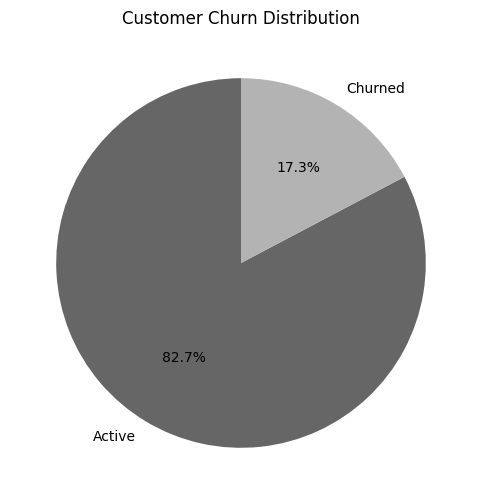

In [27]:
churn_counts = customers['ChurnLabel'].value_counts()

plt.figure(figsize=(6,6))
plt.pie(
    churn_counts, 
    labels=churn_counts.index, 
    autopct='%1.1f%%', 
    startangle=90, 
    colors=['#666666','#B3B3B3']
)
plt.title('Customer Churn Distribution')
plt.show()

In [28]:
customers.head()

,Customer ID,Segment,Region,Country,FirstPurchase,LastPurchase,Frequency,Monetary,TotalDiscount,TotalQuantity,Returns,Recency,Tenure,AOV,AvgUnitsPerOrder,DiscountRate,ReturnRate,AvgGap,ChurnThreshold,Churn,ChurnLabel,TotalDiscountAmount,DiscountAmountRate,TenureRatio,EngagementRate
0,AA-10315,Consumer,Central,United States,2014-03-31,2017-06-29,5,5563.560,1.00,30,0,184,1186,1112.712000,6.000000,0.000180,0.000000,296.50,260,0,Active,1269.910,0.185837,0.155143,0.004216
1,AA-10375,Consumer,West,United States,2014-04-21,2017-12-11,9,1056.390,1.20,41,0,19,1330,117.376667,4.555556,0.001136,0.000000,166.25,260,0,Active,43.180,0.039270,0.014286,0.006767
2,AA-10480,Consumer,South,United States,2014-05-04,2017-04-15,4,1790.512,0.20,36,0,259,1077,447.628000,9.000000,0.000112,0.000000,359.00,260,0,Active,3.888,0.002167,0.240483,0.003714
3,AA-10645,Consumer,East,United States,2014-06-22,2017-11-05,6,5086.935,1.15,64,1,55,1232,847.822500,10.666667,0.000226,0.166667,246.40,260,0,Active,719.775,0.123956,0.044643,0.004870
4,AB-10015,Consumer,West,United States,2014-02-18,2016-11-10,3,886.156,0.40,13,0,415,996,295.385333,4.333333,0.000451,0.000000,498.00,260,1,Churned,15.334,0.017010,0.416667,0.003012


In [29]:
customers.shape

(793, 25)

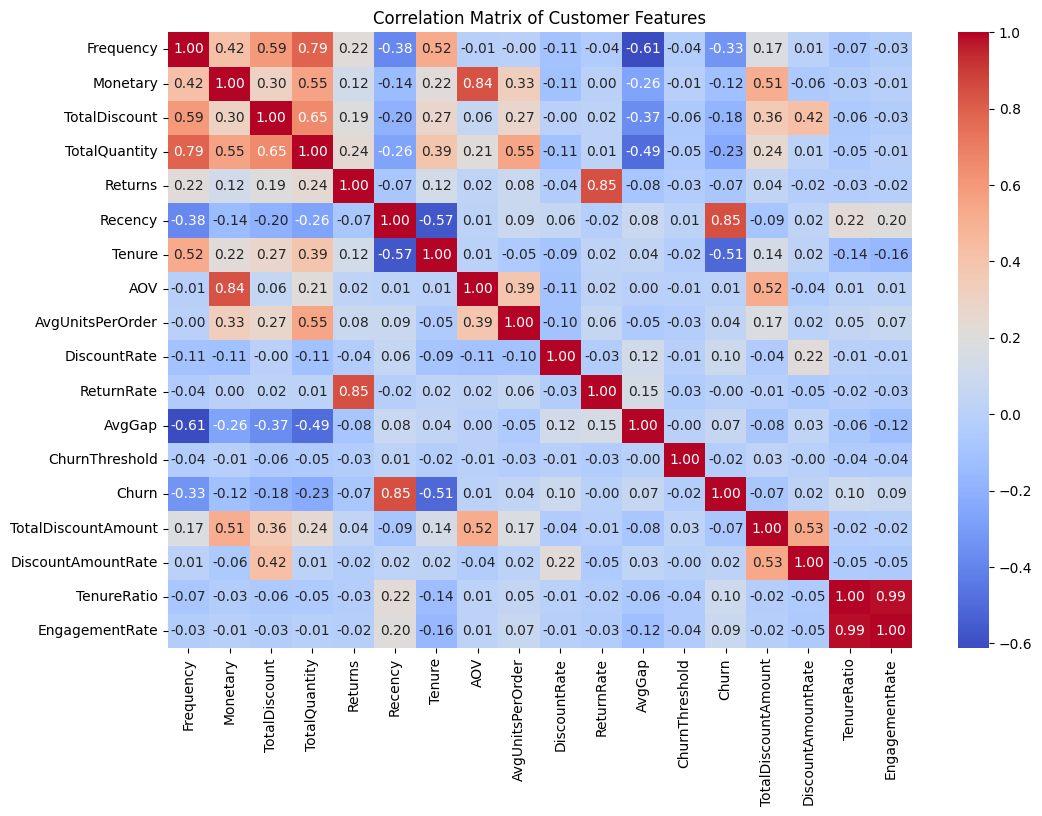

In [30]:
import matplotlib.pyplot as plt
num_cols = customers.select_dtypes(include=['number'])
corr_matrix = num_cols.corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix of Customer Features")
plt.show()


In [31]:
features = customers[['Segment','Region','Frequency','Monetary','Recency','Tenure',
 'AOV','AvgUnitsPerOrder','ReturnRate','AvgGap','DiscountAmountRate','EngagementRate','Churn']].copy()
cat_columns = ['Segment', 'Region']
num_columns =['Frequency','Monetary','Recency','Tenure',
 'AOV','AvgUnitsPerOrder','ReturnRate','AvgGap','DiscountAmountRate','EngagementRate']

In [32]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features[num_columns])
import pandas as pd
features_scaled = pd.DataFrame(features_scaled, 
                               columns=num_columns, 
                               index=features.index)

In [33]:
features_scaled.head()

,Frequency,Monetary,Recency,Tenure,AOV,AvgUnitsPerOrder,ReturnRate,AvgGap,DiscountAmountRate,EngagementRate
0,0.2500,0.222010,0.157940,0.823611,0.221784,0.210526,0.000000,0.231343,0.251345,0.004216
1,0.5000,0.041998,0.016309,0.923611,0.022964,0.134503,0.000000,0.129026,0.053113,0.006767
2,0.1875,0.071318,0.222318,0.747917,0.088932,0.368421,0.000000,0.280440,0.002931,0.003714
3,0.3125,0.202974,0.047210,0.855556,0.168872,0.456140,0.166667,0.191987,0.167651,0.004870
4,0.1250,0.035199,0.356223,0.691667,0.058521,0.122807,0.000000,0.389631,0.023006,0.003012


In [34]:
preprocessed = pd.concat([features_scaled, features[['Segment','Region','Churn']]], axis=1)

In [35]:
preprocessed = pd.get_dummies(preprocessed, columns=['Region', 'Segment'], dtype=int)

In [36]:
from sklearn.utils import resample
df_minority = preprocessed[preprocessed['Churn'] == 1]
df_majority = preprocessed[preprocessed['Churn'] == 0]
df_majority_downsampled = resample(df_majority,
                                   replace=False,                 
                                   n_samples=len(df_minority),    
                                   random_state=42)
df_balanced = pd.concat([df_majority_downsampled, df_minority])
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

In [37]:
df_balanced.shape

(274, 18)

In [38]:
df_balanced.head()

,Frequency,Monetary,Recency,Tenure,AOV,AvgUnitsPerOrder,ReturnRate,AvgGap,DiscountAmountRate,EngagementRate,Churn,Region_Central,Region_East,Region_South,Region_West,Segment_Consumer,Segment_Corporate,Segment_Home Office
0,0.375,0.180796,0.013734,0.961111,0.128833,0.255639,0.142857,0.179628,0.243626,0.005058,0,0,0,0,1,1,0,0
1,0.250,0.091895,0.330472,0.154861,0.091632,0.189474,0.200000,0.042223,0.252758,0.022422,1,1,0,0,0,1,0,0
2,0.125,0.094010,0.650644,0.304167,0.156568,0.245614,0.000000,0.170463,0.170230,0.006849,1,0,0,0,1,1,0,0
3,0.500,0.239143,0.025751,0.951389,0.132520,0.362573,0.000000,0.132954,0.298405,0.006569,0,0,0,0,1,1,0,0
4,0.250,0.121955,0.289270,0.479167,0.121701,0.210526,0.000000,0.133936,0.265295,0.007246,1,0,0,0,1,1,0,0


In [39]:
df_balanced.columns

Index(['Frequency', 'Monetary', 'Recency', 'Tenure', 'AOV', 'AvgUnitsPerOrder',
       'ReturnRate', 'AvgGap', 'DiscountAmountRate', 'EngagementRate', 'Churn',
       'Region_Central', 'Region_East', 'Region_South', 'Region_West',
       'Segment_Consumer', 'Segment_Corporate', 'Segment_Home Office'],
      dtype='object')

In [40]:
df_balanced.to_csv("customers_balancedd.csv", index=False)

In [43]:
import joblib
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']